In [3]:
import torch
from torchvision import datasets, transforms

transform = transforms.ToTensor()

train_ds = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

In [4]:
img, label = train_ds[0]
print(img.shape)
print(img.min().item(), img.max().item())

torch.Size([1, 28, 28])
0.0 1.0


In [1]:
import torch.nn as nn

class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)   # flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
import torch
from torch import optim
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = FCNN().to(device)

loader = DataLoader(train_ds, batch_size=128, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")


cuda
Epoch 1, Loss: 0.4143
Epoch 2, Loss: 0.1951
Epoch 3, Loss: 0.1434
Epoch 4, Loss: 0.1113
Epoch 5, Loss: 0.0896
Epoch 6, Loss: 0.0738
Epoch 7, Loss: 0.0616
Epoch 8, Loss: 0.0525
Epoch 9, Loss: 0.0450
Epoch 10, Loss: 0.0384


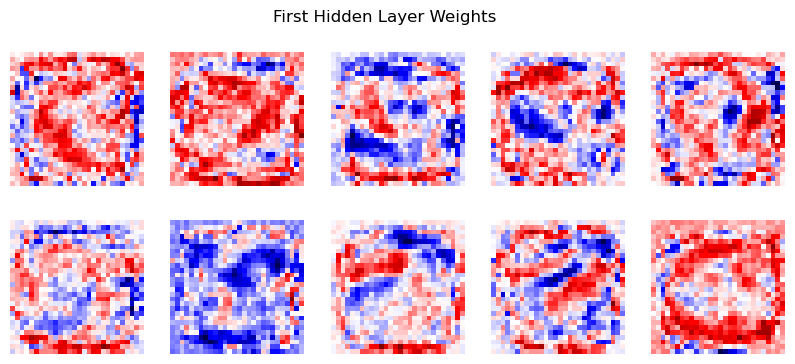

In [9]:
weights = model.fc1.weight.detach().cpu()  # shape: (128, 784)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    w = weights[i].reshape(28, 28)
    ax.imshow(w, cmap="seismic")
    ax.axis("off")

plt.suptitle("First Hidden Layer Weights")
plt.show()


In [10]:
test_ds = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)


In [11]:
model.eval()   # very important
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        outputs = model(x)              # logits
        preds = outputs.argmax(dim=1)   # predicted class

        correct += (preds == y).sum().item()
        total += y.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 97.80%


## Starting 2.1

In [12]:
perm = torch.randperm(784)


In [13]:
class Scramble(object):
    def __call__(self, img):
        x = img.view(-1)        # (784,)
        x = x[perm]             # scramble
        return x.view(1, 28, 28)

In [14]:
scrambled_transform = transforms.Compose([
    transforms.ToTensor(),
    Scramble()
])

scrambled_train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=scrambled_transform
)

scrambled_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=scrambled_transform
)


In [15]:
import torch
from torch import optim
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = FCNN().to(device)

loader = DataLoader(scrambled_train, batch_size=128, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")


cuda
Epoch 1, Loss: 0.4196
Epoch 2, Loss: 0.1959
Epoch 3, Loss: 0.1426
Epoch 4, Loss: 0.1103
Epoch 5, Loss: 0.0890
Epoch 6, Loss: 0.0743
Epoch 7, Loss: 0.0608
Epoch 8, Loss: 0.0518
Epoch 9, Loss: 0.0438
Epoch 10, Loss: 0.0381


In [16]:
model.eval()   # very important
correct = 0
total = 0
test_loader = DataLoader(scrambled_test, batch_size=256, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        outputs = model(x)              # logits
        preds = outputs.argmax(dim=1)   # predicted class

        correct += (preds == y).sum().item()
        total += y.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 97.57%
